In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
!pip install qiskit ipywidgets # while working on google colab!

In [ ]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py

In [2]:
from qbm_utils import *
from typing import Optional

## Magnetization ent-to-end 

In [3]:
def experiment_on_magnetization(n_spins, seed , num_seperate_mcmc_chains = 10 , strategy: Optional[str]= 'classical'):
    ## put n_spins even always
    
    np.random.seed(101)
    num_spins = n_spins
    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)
    J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
    J2 = 0.5 * (J + J.transpose() )
    h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

    # instantiate the model
    model = IsingEnergyFunction(J, h)

    alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
    num_elems=2**(num_spins)

    if strategy == 'classical' :
        # Run MCMC with uniform random transition strategy
        N_hops=2000
        dict_5_iter_states_distn_mcmc={}
        dict_5_iter_sprime_mcmc={}
        dict_5_iter_accepted_mcmc={}
        # num_seperate_mcmc_chains=10
        for iteration in tqdm(range(0,num_seperate_mcmc_chains)):
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept = classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, return_both_classical_and_quantum_steps=True)
            dict_5_iter_accepted_mcmc[iteration]=cl_mcmc_after_accept

        ### data for plotting running average magnetization 5 cases seperately:
        first_few=500
        cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_5_iter_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]

        # array first_few_iterations X number of seperate mcmc chains:
        array_avg_mag_diff_chains=np.zeros((first_few, num_seperate_mcmc_chains))
        for i in range(0, num_seperate_mcmc_chains):
            array_avg_mag_diff_chains[:,i]=list(cl_running_avg_magzn[i].values())

        mean_mag_iterations=np.mean(array_avg_mag_diff_chains, axis=1)
        std_dev=np.std(array_avg_mag_diff_chains, axis=1)

        ## save data
        columns = ['mcmc_'+str(i) for i in range(num_seperate_mcmc_chains)]
        df = pd.DataFrame(array_avg_mag_diff_chains,columns = columns)
        df.to_csv('magn_classical:' + '['+'spins='+ str(n_spins)+ ', seed='+ str(seed)+ '].csv')

    if strategy == 'quantum' :
        # Run MCMC with uniform random transition strategy
        N_hops=2000
        dict_5_iter_states_distn_mcmc={}
        dict_5_iter_sprime_mcmc={}
        dict_5_iter_accepted_mcmc={}
        # num_seperate_mcmc_chains=10
        for iteration in tqdm(range(0,num_seperate_mcmc_chains)):
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept = quantum_enhanced_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, alpha= alpha, return_both_classical_and_quantum_steps=True)
            dict_5_iter_accepted_mcmc[iteration]=cl_mcmc_after_accept

        ### data for plotting running average magnetization 5 cases seperately:
        first_few=500
        cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_5_iter_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]

        # array first_few_iterations X number of seperate mcmc chains:
        array_avg_mag_diff_chains=np.zeros((first_few, num_seperate_mcmc_chains))
        for i in range(0, num_seperate_mcmc_chains):
            array_avg_mag_diff_chains[:,i]=list(cl_running_avg_magzn[i].values())

        mean_mag_iterations=np.mean(array_avg_mag_diff_chains, axis=1)
        std_dev=np.std(array_avg_mag_diff_chains, axis=1)

        ## save data
        columns = ['mcmc_'+str(i) for i in range(num_seperate_mcmc_chains)]
        df = pd.DataFrame(array_avg_mag_diff_chains,columns = columns)
        df.to_csv('magn_quantum:' + '['+'spins='+ str(n_spins)+ ', seed='+ str(seed)+ '].csv')
  

In [10]:
experiment_on_magnetization(8, 1201, strategy= 'classical')

  0%|          | 0/10 [00:00<?, ?it/s]

starting with:  01111111


 10%|█         | 1/10 [00:01<00:11,  1.25s/it]

starting with:  10101010


 20%|██        | 2/10 [00:02<00:10,  1.26s/it]

starting with:  00011111


 30%|███       | 3/10 [00:03<00:08,  1.16s/it]

starting with:  00011100


 40%|████      | 4/10 [00:04<00:06,  1.12s/it]

starting with:  01110101


 50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

starting with:  01100111


 60%|██████    | 6/10 [00:06<00:04,  1.05s/it]

starting with:  00101111


 70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

starting with:  11110001


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

starting with:  00000011


 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]

starting with:  10001111


100%|██████████| 500/500 [00:01<00:00, 315.44it/s] 


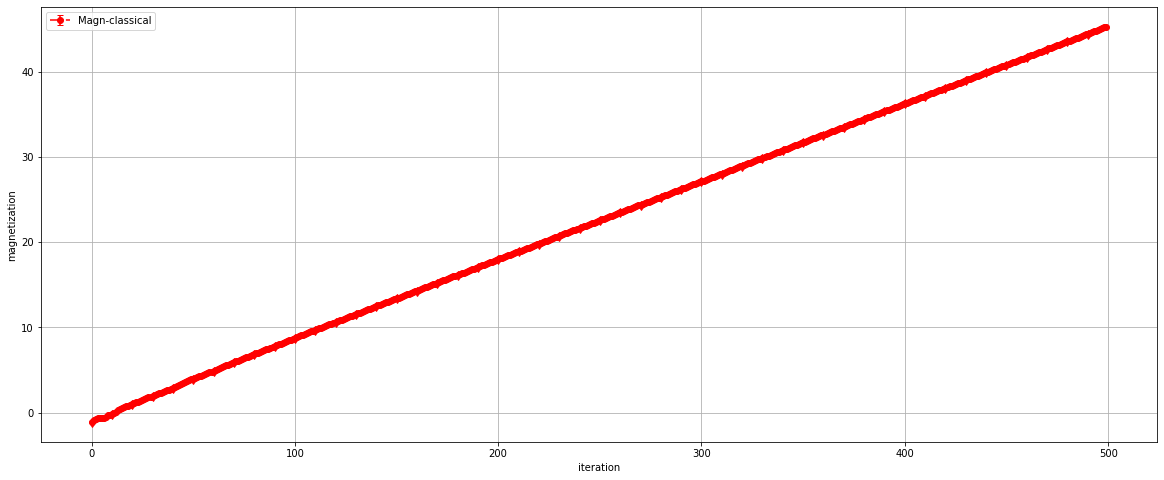

In [11]:
df_t = pd.read_csv('/home/rajarsi/Documents/QBMS/qbm_git/qbm_codes/magn_classical:[spins=8, seed=124101].csv')
index = list(df_t.index)
index = [int(j) for j in index]
fig = plt.figure(figsize=(20,8))
# plt.plot(np.linspace(0,45,5),np.linspace(0,45,5), linestyle='dotted', label= 'KYd = d')
plt.grid(True)
plt.errorbar(index, df_t.mean(axis=1), yerr= df_t.std(axis=1), errorevery= 10 ,label = 'Magn-classical',uplims= True, lolims=True, marker= 'o', color= 'r',linestyle='dashdot')
plt.xlabel("iteration")
plt.ylabel("magnetization")
plt.legend()
# plt.title('KYd vs. d (statistics)')

### Define your model

In [12]:
# define the model
## put n_spins even always
n_spins = 8

np.random.seed(101)
## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J2 = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


### Some updated funcs

In [6]:
def classical_mcmc(N_hops:int, num_spins:int, num_elems:int, model, return_last_n_states=500, return_both_classical_and_quantum_steps=False ):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 

    ## initialiiise observables
    #observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        states.append(current_state)
        # get sprime
        s_prime=classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state= next_state
        list_after_acceptance_step.append(current_state)
        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    # returns dictionary of occurences for last "return_last_n_states" states
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])
    
    if return_both_classical_and_quantum_steps: 
        to_return = dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
        to_return= dict_count_return_last_n_states 
    
    return to_return

In [7]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, return_both_classical_and_quantum_steps=False):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    #observable_dict = dict([ ( elem, []  ) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state=next_state
        # if current_state!=next_state:# this seems to be a redundant step. I could have set current_state=classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        #   current_state= next_state
        list_after_acceptance_step.append(current_state)

        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
      
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])#dictionary of occurences for last "return_last_n_states" states

    if return_both_classical_and_quantum_steps: 
      to_return= dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
      to_return= dict_count_return_last_n_states

    return to_return

### Some new helper functions

In [8]:
# some new helper functions
def states(num_spins:int)->list:
    ''' 
    Returns all possible binary strings of length n=num_spins

    Args:
    num_spins: n length of the bitstring
    Returns:
    possible_states= list of all possible binary strings of length num_spins
    '''
    num_possible_states=2**(num_spins)
    possible_states=[f'{k:0{num_spins}b}' for k in range(0,num_possible_states)]
    return possible_states

def magnetization_of_state(bitstring:str)->float:
    '''  
    Args:
    bitstring: for eg: '010'
    Returns:
    magnetization for the given bitstring
    '''
    array=np.array(list(bitstring))
    num_times_one=np.count_nonzero(array=='1')
    num_times_zero=len(array)-num_times_one
    magnetization=num_times_one-num_times_zero
    return magnetization

def dict_magnetization_of_all_states(list_all_possible_states:list)->dict:
    '''
    Returns magnetization for all unique states
    
    Args:
    list_all_possible_states
    Returns:
    dict_magnetization={state(str): magnetization_value}
    '''
    list_mag_vals=[magnetization_of_state(state) for state in list_all_possible_states]
    dict_magnetization=dict(zip(list_all_possible_states, list_mag_vals ))
    #print("dict_magnetization:"); print(dict_magnetization)
    return dict_magnetization
  
def value_sorted_dict(dict_in, reverse=False):

  sorted_dict={k: v for k, v in sorted(dict_in.items(), key=lambda item: item[1], reverse=reverse)}
  return sorted_dict


## enter samples, get normalised distn
def get_distn(list_of_samples:list)-> dict:
  '''   
  Returns the dictionary of distn for input list_of_samples
  '''
  len_list=len(list_of_samples)
  temp_dict=Counter(list_of_samples)
  temp_prob_list=np.array(list(temp_dict.values()))*(1./len_list)
  dict_to_return=dict(zip( list(temp_dict.keys()), temp_prob_list))
  return dict_to_return


## Average
def avg(dict_probabilities:dict, dict_observable_val_at_states:dict):
  ''' 
  Returns average of any observable of interest

  Args:
  dict_probabilities= {state: probability}
  dict_observable_val_at_states={state (same as that of dict_probabilities): observable's value at that state}

  Returns:
  avg
  '''
  len_dict=len(dict_probabilities)
  temp_array=np.zeros((len_dict,))
  temp_list=[dict_probabilities[j]*dict_observable_val_at_states[j] for j in (list(dict_probabilities.keys())) ]
  avg=np.mean(temp_list)
  return avg

### function to get running average of magnetization
def running_avg_magnetization(list_states_mcmc:list):
  ''' 
  Returns the running average magnetization 

  Args:
  list_states_mcmc= List of states aceepted after each MCMC step
  '''
  len_iters_mcmc=len(list_states_mcmc)
  running_avg_mag={}
  for i in tqdm(range(1,len_iters_mcmc)):
    temp_list=list_states_mcmc[:i]#[:i]
    temp_prob=get_distn(temp_list)
    dict_mag_states_in_temp_prob=dict_magnetization_of_all_states(temp_list)
    running_avg_mag[i]=avg(temp_prob, dict_mag_states_in_temp_prob)
  return running_avg_mag



## Plotting related
def plot_dict_of_running_avg_observable(dict_running_avg:dict, observable_legend_label:str):
  plt.plot(list(dict_running_avg.keys()), list(dict_running_avg.values()),"-" ,label=observable_legend_label)
  plt.xlabel("MCMC iterations")

def plot_bargraph_desc_order(desc_val_order_dict_in:dict, label:str, normalise_complete_data:bool=False,plot_first_few:int=0):
  width=1.0
  list_keys=list(desc_val_order_dict_in.keys())
  list_vals=list(desc_val_order_dict_in.values())
  if normalise_complete_data:
    list_vals=np.divide(list_vals, sum(list_vals))#np.divide(list(vals), sum(vals))
  if plot_first_few!=0:
    plt.bar(list_keys[0:plot_first_few], list_vals[0:plot_first_few], label=label)
  else:
    plt.bar(list_keys, list_vals, label=label)
  plt.xticks(rotation=45)

def plot_multiple_bargraphs(list_of_dicts:list,list_labels:list,list_normalise:list ,plot_first_few,  sort_desc=False,sort_asc=False, figsize=(15,7)):
  list_keys=list(list_of_dicts[0].keys())
  dict_data={}
  for i in range(0,len(list_labels)):
    #list_vals=[list_of_dicts[i][j] for j in list_keys if j in list(list_of_dicts[i].keys()) else 0] #list(list_of_dicts[i].values())
    list_vals=[list_of_dicts[i][j] if j in list(list_of_dicts[i].keys()) else 0 for j in list_keys]
    if list_normalise[i]:
      list_vals=np.divide(list_vals, sum(list_vals))
    dict_data[list_labels[i]]=list_vals
  df=pd.DataFrame(dict_data, index=list_keys)
  if sort_desc:
    df_sorted_desc=df.sort_values(list_labels[0], ascending=False)
    df_sorted_desc[:plot_first_few].plot.bar(rot=90,figsize=figsize)
  elif sort_asc:
    df_sorted_asc=df.sort_values(list_labels[0], ascending=True)
    df_sorted_asc[:plot_first_few].plot.bar(rot=90,figsize=figsize)
  elif (sort_desc==False and sort_asc==False):
    df[:plot_first_few].plot.bar(rot=90,figsize=figsize)


# function to create dict for number of times states sprime were not accepted in MCMC iterations
def fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept, bitstring):

  where_sprime_is_bitstr=list(np.where( np.array(list_after_trsn) == bitstring)[0])
  where_bitstr_not_accepted=[k for k in where_sprime_is_bitstr if list_after_accept[k]!=bitstring]
  numtimes_sprime_is_bitstring= len(where_sprime_is_bitstr)
  numtimes_bitstring_not_accepted=len(where_bitstr_not_accepted)
  return numtimes_bitstring_not_accepted, numtimes_sprime_is_bitstring

def fn_states_not_accepted(list_states:list, list_after_trsn:list, list_after_accept:list):
  list_numtimes_state_not_accepted=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[0] for k in list_states]
  list_numtimes_sprime_is_state=[fn_numtimes_bitstring_not_accepted(list_after_trsn, list_after_accept,k)[1] for k in list_states]
  dict_numtimes_states_not_accepted=dict(zip(list_states, list_numtimes_state_not_accepted))
  dict_numtimes_sprime_is_state=dict(zip(list_states, list_numtimes_sprime_is_state))
  return dict_numtimes_states_not_accepted, dict_numtimes_sprime_is_state

In [9]:
states_nbit=states(num_spins=n_spins)

# Actual_probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
#print(rqd_sum)
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )

## Run classical MCMC

In [32]:
# define the model
## put n_spins even always
n_spins = 8

np.random.seed(101)
## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J2 = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )

# symmetric uniform transition matrix for uniform transition rule
num_spins=n_spins#4
num_elems=2**(num_spins)
# transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
# np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy

N_hops=200
dict_5_iter_states_distn_mcmc={}
dict_5_iter_sprime_mcmc={}
dict_5_iter_accepted_mcmc={}
num_seperate_mcmc_chains=10
for iteration in tqdm(range(0,num_seperate_mcmc_chains)):
    # dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept = classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, return_both_classical_and_quantum_steps=True)
    dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept = quantum_enhanced_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, alpha= alpha, return_both_classical_and_quantum_steps=True)
    dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)
    
    # dict_5_iter_states_distn_mcmc[iteration]=dict_states_mcmc_sorted_desc
    # dict_5_iter_sprime_mcmc[iteration]=cl_mcmc_after_trsn
    dict_5_iter_accepted_mcmc[iteration]=cl_mcmc_after_accept

### data for plotting running average magnetization 5 cases seperately:
first_few=100
cl_running_avg_magzn=[running_avg_magnetization(list_states_mcmc=dict_5_iter_accepted_mcmc[m][:first_few+1]) for m in range(0,num_seperate_mcmc_chains)]

# array first_few_iterations X number of seperate mcmc chains:
array_avg_mag_diff_chains=np.zeros((first_few, num_seperate_mcmc_chains))
for i in range(0, num_seperate_mcmc_chains):
    array_avg_mag_diff_chains[:,i]=list(cl_running_avg_magzn[i].values())

# mean_mag_iterations=np.mean(array_avg_mag_diff_chains, axis=1)
# std_dev=np.std(array_avg_mag_diff_chains, axis=1)

columns = ['mcmc_'+str(i) for i in range(num_seperate_mcmc_chains)]
df_t = pd.DataFrame(array_avg_mag_diff_chains,columns = columns)
df_t

  0%|          | 0/10 [00:00<?, ?it/s]

starting with:  01111111


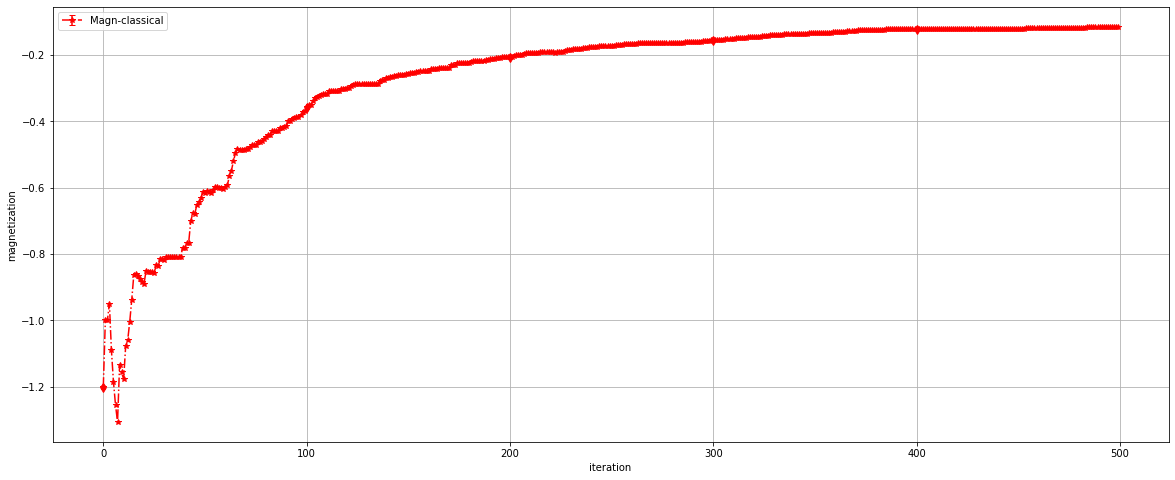

In [28]:
index = list(df_t.index)
index = [int(j) for j in index]
fig = plt.figure(figsize=(20,8))
# plt.plot(np.linspace(0,45,5),np.linspace(0,45,5), linestyle='dotted', label= 'KYd = d')
plt.grid(True)
plt.errorbar(index, df_t.mean(axis=1), yerr= df_t.std(axis=1), errorevery= 100 ,label = 'Magn-classical',uplims= True, lolims=True, marker= '*', color= 'r',linestyle='dashdot')
plt.xlabel("iteration")
plt.ylabel("magnetization")
plt.legend()

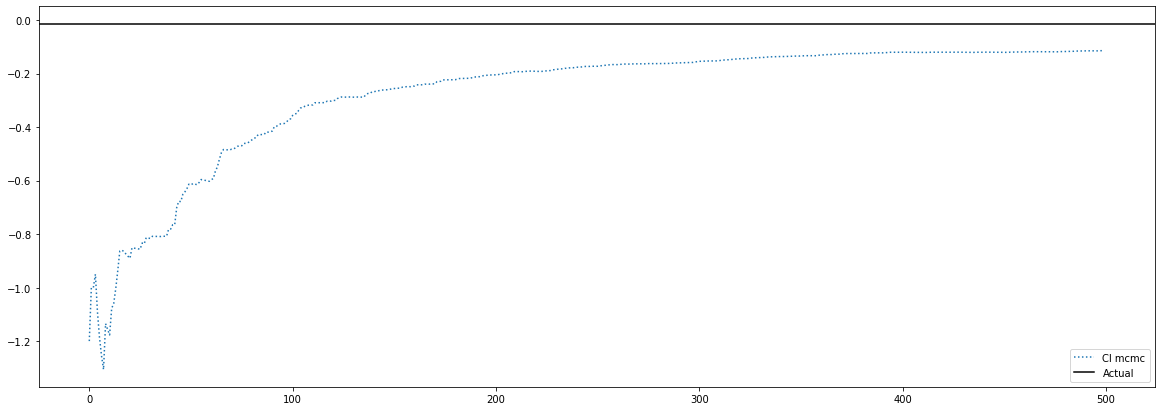

In [16]:
plt.figure(figsize=(20,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.plot(mean_mag_iterations,":" ,label="Cl mcmc")
plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()

In [ ]:
### Sampling related

list_of_dict_state_not_accepted=[]
list_of_dict_sprime_occured=[]
for i in tqdm(range(0,num_seperate_mcmc_chains)):
    dict_numtimes_state_not_accepted, dict_numtimes_sprime=fn_states_not_accepted(list_states=states_nbit,
    list_after_trsn=dict_5_iter_sprime_mcmc[i], 
    list_after_accept= dict_5_iter_accepted_mcmc[i])
    list_of_dict_state_not_accepted.append(dict_numtimes_state_not_accepted)
    list_of_dict_sprime_occured.append(dict_numtimes_sprime)

numtimes_sprime_rejected_array=np.zeros((num_elems,num_seperate_mcmc_chains))
numtimes_sprime_occured_array=np.zeros((num_elems,num_seperate_mcmc_chains))
for i in range(0, num_seperate_mcmc_chains):
    numtimes_sprime_rejected_array[:,i]=list(list_of_dict_state_not_accepted[i].values())
    numtimes_sprime_occured_array[:,i]=list(list_of_dict_sprime_occured[i].values())

avg_sprime_rejected=list(np.mean(numtimes_sprime_rejected_array, axis=1))
std_dev_sprime_rejected=np.std(numtimes_sprime_rejected_array, axis=1)
avg_sprime_occured=list(np.mean(numtimes_sprime_occured_array, axis=1))

dict_avg_times_sprime_rejected=dict(
    zip(
    list(dict_numtimes_state_not_accepted.keys()),avg_sprime_rejected
    )
    )

dict_avg_times_sprime_occured=dict(
    zip(
    list(dict_numtimes_sprime.keys()),avg_sprime_occured
    )
    )

print(avg_sprime_rejected)

100%|██████████| 10/10 [00:01<00:00,  5.36it/s]

[7.7, 7.4, 6.6, 8.7, 6.9, 8.4, 6.6, 5.7, 6.7, 7.1, 7.4, 7.7, 9.2, 7.7, 7.5, 7.8, 7.1, 8.3, 7.4, 7.5, 6.2, 7.4, 5.5, 8.1, 7.5, 8.0, 7.1, 7.2, 8.0, 8.7, 8.4, 7.4, 8.3, 6.8, 6.9, 7.1, 7.8, 7.4, 7.6, 7.4, 7.4, 9.0, 8.3, 6.9, 9.2, 7.3, 7.8, 6.8, 7.1, 6.9, 7.5, 6.1, 6.7, 7.5, 8.0, 7.8, 6.8, 8.3, 9.3, 7.3, 7.8, 7.8, 7.1, 8.0, 7.2, 8.1, 6.3, 6.1, 8.4, 9.0, 4.9, 5.1, 6.3, 8.0, 8.5, 7.8, 8.8, 7.7, 6.7, 8.3, 8.2, 8.2, 5.1, 5.4, 9.5, 7.8, 6.6, 4.1, 9.3, 7.3, 9.0, 8.1, 8.0, 7.8, 7.9, 6.8, 5.5, 8.6, 6.9, 8.7, 7.9, 8.3, 7.6, 7.9, 7.2, 8.5, 8.3, 8.4, 7.0, 6.1, 6.9, 6.9, 7.4, 8.5, 7.8, 6.9, 9.7, 8.2, 8.5, 8.1, 8.0, 8.7, 8.3, 7.1, 8.3, 6.5, 8.9, 8.2, 7.3, 6.4, 6.8, 6.2, 6.3, 7.7, 4.9, 5.5, 8.6, 8.1, 7.8, 10.6, 8.1, 7.9, 7.2, 7.8, 10.1, 8.0, 8.3, 8.3, 7.3, 9.7, 6.1, 7.2, 5.3, 6.8, 7.6, 7.2, 7.6, 8.9, 7.1, 7.6, 7.6, 8.8, 8.0, 7.4, 6.6, 9.0, 8.4, 8.5, 7.9, 7.6, 8.1, 7.1, 7.7, 8.2, 7.7, 8.7, 7.8, 7.7, 9.1, 6.9, 9.1, 6.7, 7.0, 7.9, 8.3, 8.1, 7.8, 8.4, 8.0, 9.1, 9.2, 8.4, 6.5, 6.0, 2.3, 5.0, 6.1, 6.1, 0.0, 0.

In [ ]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,1,1)
# plot_bargraph_desc_order(boltz_prob_distn,label="theoretical", plot_first_few=30)   
# plt.legend()
# plt.subplot(2,1,2)
# plot_bargraph_desc_order(dict_states_mcmc,label="MCMC-uniform", normalise_complete_data=True)  
# plt.legend()
# # plot_bargraph(boltz_prob_distn,label="theoretical",plot_first_few=60)  
# # plot_bargraph(dict_states_mcmc,label="MCMC-Uniform",normalise_complete_data=True,plot_first_few=60)  
# plot_multiple_bargraphs([boltz_prob_distn,dict_states_mcmc], ["theory", "MCMC-Uniform random"], list_normalise=[True,True], plot_first_few=30, sort_desc=True)
# # plt.legend()

In [ ]:
# # get actual probability distribution
# transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# # plot actual prob distribution as well as one obtained from MCMC
# #dict_states_mcmc_plot=dict(zip(list(range(0,2**(num_spins))), list(dict_states_mcmc.values()) ))
# plot_histogram( [boltz_prob_distn, dict_states_mcmc] , figsize=(20, 7), legend= ['model', 'MCMC-uniform'], bar_labels=False, sort="value_desc")

## Run quantum enhanced MCMC

In [ ]:
# symmetric uniform transition matrix for uniform transition rule: tho tbh I dont need it
num_spins=n_spins#4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=600
dict_states_quantum_mcmc, quant_mcmc_after_trsn, quant_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, 
num_spins, num_elems, model, alpha, num_trotter_steps=10, 
return_last_n_states=300,return_both_classical_and_quantum_steps=True)

starting with:  00011101


100%|██████████| 600/600 [03:59<00:00,  2.51it/s]


In [ ]:
# get actual probability distribution
#transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [boltz_prob_distn, dict_states_quantum_mcmc] , figsize=(20, 7), legend= ['model', 'Quantum-enhanced MCMC' ], sort= 'value_desc')

In [ ]:
fig = plot_histogram( [boltz_prob_distn,dict_states_quantum_mcmc] , figsize=(40, 15), legend= ["model", "Quantum" ], bar_labels=False)
fig

In [ ]:
plot_histogram( [boltz_prob_distn,dict_states_mcmc, dict_states_quantum_mcmc] , figsize=(40, 15), legend= ['model', 'classical MCMC: Uniform','Quantum-enhanced MCMC' ], sort='value_desc', bar_labels=False)

In [ ]:
# transits_bltz

In [ ]:
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
#print(rqd_sum)
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
boltz_prob_distn=dict(zip(list(transits_bltz.keys()), prob_vals ))
print(boltz_prob_distn)

### comparing number of accepted/rejected samples

In [ ]:
# plt.figure(figsize=(20,7))
# plt.plot(cl_mcmc_after_trsn, label="Classical Uniform")
# plt.plot(quant_mcmc_after_trsn, label="Quantum")
# plt.xlabel("MCMC iterations")
# plt.title("after transition")
plt.figure(figsize=(10,10))
#quant_mcmc_after_trsn, quant_mcmc_after_accept
plt.plot(cl_mcmc_after_accept, label="Classical Uniform")
plt.plot(quant_mcmc_after_accept,label="Quantum")
plt.xlabel("MCMC iterations")
plt.title("State accepted in i'th iteration")
plt.legend()

Next task:
For different problem instances, do the following:

1. Running average: magnetization. **(DONE)**

2.  For first few relevant states (high probability), check how many times were those states accepted/rejected out of total number of iterations considered for the prob distn. **(CODE IS COMPLETE, NOW WE NEED TO RUN SOME EXPERIEMENTS)**

3. Overlap with the desired distribution.


## Running average; magnetization

In [ ]:
check_cl=running_avg_magnetization(list_states_mcmc=cl_mcmc_after_accept)
check_quant=running_avg_magnetization(list_states_mcmc=quant_mcmc_after_accept)

100%|██████████| 599/599 [00:00<00:00, 811.41it/s]


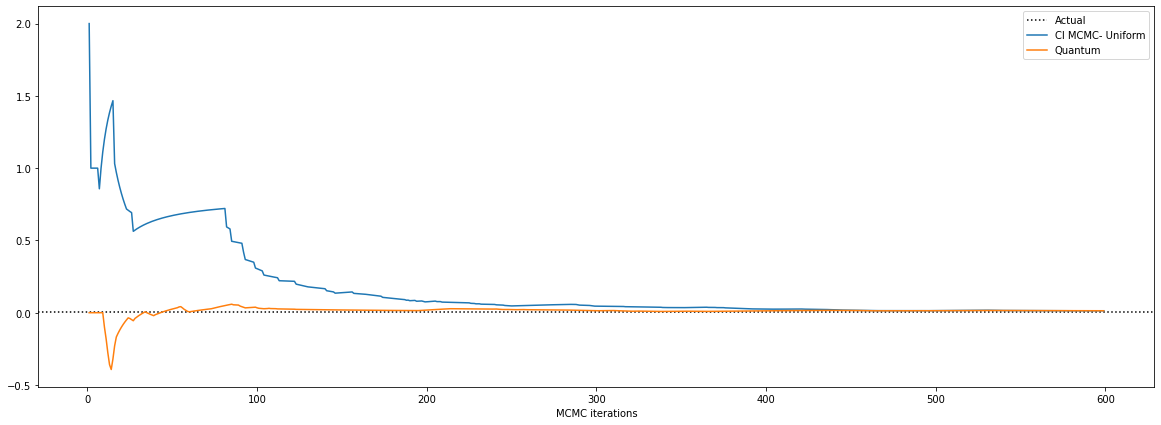

In [ ]:
plt.figure(figsize=(20,7))
magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)
plt.axhline(y=actual_avg_mag,linestyle=":", color="k" ,label="Actual")
plot_dict_of_running_avg_observable(check_cl, "Cl MCMC- Uniform")
plot_dict_of_running_avg_observable(check_quant, "Quantum")
plt.legend()

## Sampling related

In [ ]:
# cl_mcmc_after_trsn, cl_mcmc_after_accept
# quant_mcmc_after_trsn, quant_mcmc_after_accept 
aa,bb=fn_states_not_accepted(list_states=states_nbit, list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept)
print(aa); print(bb)
# fn_numtimes_bitstring_not_accepted(list_after_trsn=cl_mcmc_after_trsn, list_after_accept=cl_mcmc_after_accept,bitstring='0000')